# Chapter 10: Beam Theory: Architecture for Cells and Skeletons 

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import mpmath

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D # For 3D plots

# Seaborn, useful for graphics
import seaborn as sns

# Import the default plotting style
import plotting_style as pstyle

# Function to import and display images from the Garland website
from IPython.display import Image

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Define directories
figdir = '../fig/'

In [2]:
# Set plotting style
pstyle.set_plotting_style()

## 10.1 D Persistence length and Fourier analysis

d) Make use of the identity $\left\langle \cos X \right\rangle = e^{−\left\langle X^2 \right\rangle/2}$, which holds for a Gaussian distributed random variable $X$, to obtain the equation for the tangent–tangent correlation function, $\left\langle t(s) \cdot t(0)\right\rangle = e^{−\theta(s)^2 / 2}$. Then compute $\left\langle \theta(s)^2\right\rangle$ by using the Fourier series representation of $\theta (s)$ and the average values of the Fourier amplitudes $\tilde \theta$ obtained in (c). Convince yourself either by plotting or Fourier analysis that on the interval $0 < s < L$, $\left\langle \theta(s)^2\right\rangle = {s \over \xi_p}$.

### Solution

We arrived to the solution that the average value of the angle squared $\left\langle \theta(s)^2\right\rangle$ is of the form
$$
\left\langle \theta(s)^2\right\rangle = {L \over \xi_p}
\sum_{n = 1}^\infty {8 \over [(2n -1)\pi]^2} 
\sin^2\left( {(2n - 1)\pi \over 2L}s \right).
$$
Let's define a function that performs this sum up to a specific $n$ and see to which value it converges as we add more and more terms.

In [3]:
def avg_theta_sqr(n, s, L=1, xi_p=0.1):
    '''
    Computes the average value of the angle squared
    '''
    # Initialize array to save each entry for each n and s value
    theta_sq = np.zeros([n, len(s)])
    
    # Loop through n and compute s
    for i in range(1, n + 1):
        theta_sq[i-1, :] = (L / xi_p) * (8 / ((2 * i - 1) * np.pi)**2) *\
                         np.sin((2 * i - 1) * np.pi / (2 * L) * s)**2
        
    return theta_sq

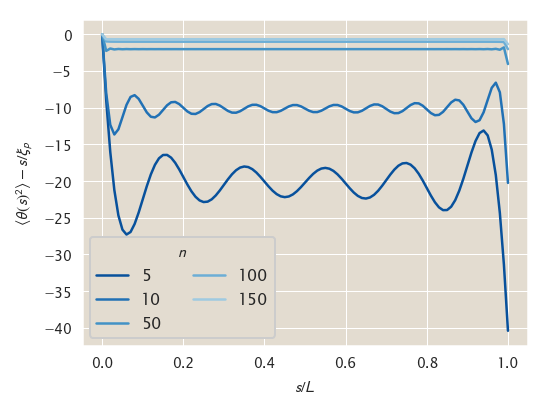

In [12]:
# Define range of s values
L = 1
s_array = np.linspace(0, L, 101)
xi_p = L / 1000

# Compute sum up to 100
theta_sq = avg_theta_sqr(150, s_array, L, xi_p)

##   Plot partial sums

# Define partial sums to plot
n_plot = [5, 10, 50, 100, 150]

# Define colors
colors = sns.color_palette('Blues_r', n_colors=len(n_plot)+2)

# Loop through partial plots
for i, n in enumerate(n_plot):
    # Plot partial sum
    plt.plot(s_array, theta_sq[0:n, :].sum(axis=0) - s_array / xi_p,
             label=str(n), color=colors[i])

# Label axis
plt.xlabel(r'$s / L$')
plt.ylabel(r'$\left\langle \theta(s)^2 \right\rangle - s / \xi_p$')

# Add legend
plt.legend(title='$n$', ncol=2)

# Save figure
plt.savefig(figdir + 'problem_10_01_04.png', bbox_inches='tight',
            dpi=300)